In [1]:
import csv
import math
import os
import pickle
import scipy
import time
import zipfile

import numpy  as np
import pandas as pd
import tensorflow as tf

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Lambda, Input
from keras.models import load_model, Model, model_from_json
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras import backend as K
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
INPUTS_FNAME   = "lfw_datasets_and_models.zip"

PATH_INPUTS_FNAME     = "./lfw_datasets_and_models.zip" 
PATH_INPUTS           = "./test/lfw_datasets_and_models"

PATH_DATASET_BASE     = PATH_INPUTS + "/datasets"

PATH_DATASET_BASE_MASKED   = PATH_DATASET_BASE + "/masked"
PATH_DATASET_BASE_UNMASKED = PATH_DATASET_BASE + "/unmasked"

PATH_DATASET_MASKED_TRAIN = PATH_DATASET_BASE_MASKED + "/train/"
PATH_DATASET_MASKED_VAL   = PATH_DATASET_BASE_MASKED + "/validation/"
PATH_DATASET_MASKED_TEST  = PATH_DATASET_BASE_MASKED + "/test/"

PATH_DATASET_UNMASKED_TRAIN = PATH_DATASET_BASE_UNMASKED + "/train/"
PATH_DATASET_UNMASKED_VAL   = PATH_DATASET_BASE_UNMASKED + "/validation/"
PATH_DATASET_UNMASKED_TEST  = PATH_DATASET_BASE_UNMASKED + "/test/"

PATH_TRAIN_RESNET = PATH_INPUTS + '/models/resnet'
PATH_TRAIN_FACENET = PATH_INPUTS + '/models/facenet'

PATH_FACENET_KERAS_H5 = PATH_INPUTS + "/models/facenet/keras-facenet/model/facenet_keras.h5"

In [3]:
def extract_zipfile(filename: str, extract_dirname: str, extract_path: str):
    # Extract the inputs from the zip file.
    if (not os.path.isdir(extract_dirname)):
        print("[INFO] Extracting from '{}' to '../'...".format(filename), end=" ")
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(extract_path)
        print("DONE.")
    else:
        print("[INFO] Directory '{}' exists.".format(extract_dirname))

#extract_zipfile(PATH_INPUTS_FNAME, PATH_INPUTS, "./")

In [4]:
# [Retraining]
TRAINING_IMAGES_COUNT = 260

masked_path = []
masked_dict = {}
unmasked_path = []
training_path = []
for subdir in os.listdir(PATH_DATASET_MASKED_TRAIN):
    filenames = os.listdir(PATH_DATASET_MASKED_TRAIN + subdir)
    filename = PATH_DATASET_MASKED_TRAIN + subdir + "/" + filenames[0]
    masked_path.append((subdir, filename))
    masked_dict[subdir] = filename

for subdir in os.listdir(PATH_DATASET_UNMASKED_TRAIN):
    filenames = os.listdir(PATH_DATASET_UNMASKED_TRAIN + subdir)
    filename = PATH_DATASET_UNMASKED_TRAIN + subdir + "/" + filenames[0]
    unmasked_path.append((subdir, filename))

print(len(masked_path))
print(len(unmasked_path))

masked_count = len(masked_path)
unmasked_count = len(unmasked_path)
neg = np.random.randint(masked_count, size=unmasked_count)
for i in range(TRAINING_IMAGES_COUNT):
    a_name, a_path = unmasked_path[i]
    if a_name not in masked_dict:
        continue
    pos_path = masked_dict[a_name]
    if (a_name != masked_path[neg[i]][0]):
        neg_path = masked_path[neg[i]][1]
    else:
        neg_path = masked_path[neg[i+1]][1]
    training_path.append((a_path, pos_path, neg_path))
        
print(len(training_path))

5721
5749
258


In [5]:
# [Retraing]
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1.8 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
        
    returned_loss = K.mean(loss)
    return returned_loss

In [6]:
# [Retraining]
# Used when compiling the siamese network
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)  # This is actually just returning y_pred bcs
                                        # K.mean has already been called in the triplet_loss function

In [7]:
# [Retraining]
model = ResNet50(weights='imagenet')
print(len(model.layers))
model.layers.pop()
model.summary()














177
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [8]:
layers_count = len(model.layers)
for i in range(layers_count):
    layer = model.layers[i]
    if i < layers_count//2:
        layer.trainable = False # Freeze first half of layers.
    elif layer.trainable and not layer.name.startswith("bn"):
        layer.trainable = False # Leave all BatchNorm layers to retrain.

last_layer = model.layers[layers_count - 1]
last_layer.trainable = True # Mark last layer to retrain.

model.summary()
for layer in model.layers:
    print(layer.name + " : " + str(layer.trainable))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
# [Retraining]
# Define the siamese ResNet network

image_shape = (224, 224, 3)

x = last_layer.output
model_out = Dense(128, activation='relu',  name='model_out')(x)
model_out = Lambda(lambda  x: K.l2_normalize(x, axis=-1))(model_out)

new_model = Model(inputs=model.input, outputs=model_out)

anchor_input = Input(shape=image_shape, name='anchor_input')
pos_input = Input(shape=image_shape, name='pos_input')
neg_input = Input(shape=image_shape, name='neg_input')

encoding_anchor = new_model(anchor_input)
encoding_pos = new_model(pos_input)
encoding_neg = new_model(neg_input)

loss = Lambda(triplet_loss)([encoding_anchor, encoding_pos, encoding_neg])

siamese_model = Model(inputs  = [anchor_input, pos_input, neg_input], outputs = loss)
siamese_model.compile(optimizer=Adam(lr=.05, clipnorm=1.), loss=identity_loss)
siamese_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
neg_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          23849984    anchor_input[0][0]               
                                                                 pos_input[0][0]                  
         

In [10]:
EPOCHS_COUNT = 25
BATCH_SIZE = 32

image_input_shape = (0, 224, 224, 3)
image_target_shape = (224, 224)
training_loss = []

for epoch in range(EPOCHS_COUNT):
    t = time.time()
    for batch in range(len(training_path)//BATCH_SIZE):
        anchor_imgs = np.empty(image_input_shape)
        pos_imgs = np.empty(image_input_shape)
        neg_imgs = np.empty(image_input_shape)
        start = batch * BATCH_SIZE
        end = start + BATCH_SIZE
        # print("    Batch from " + str(start) + " to " + str(end))
        for i in range (start, end):
            anchor_path, pos_path, neg_path = training_path[i]
            #print(anchor_path)
            anchor_img = image.load_img(anchor_path, target_size=image_target_shape)
            anchor_img = image.img_to_array(anchor_img)
            #print(anchor_imgs.shape)
            anchor_img = np.expand_dims(anchor_img, axis=0)
            #print(anchor_imgs.shape)
            anchor_img = preprocess_input(anchor_img)
            anchor_imgs = np.append(anchor_imgs, anchor_img, axis=0)
            #print(anchor_img.shape)

            #print(test_path)
            pos_img = image.load_img(pos_path, target_size=image_target_shape)
            pos_img = image.img_to_array(pos_img)
            pos_img = np.expand_dims(pos_img, axis=0)
            pos_img = preprocess_input(pos_img)
            pos_imgs = np.append(pos_imgs, pos_img, axis=0)
            #print(pos_img.shape)

            neg_img = image.load_img(neg_path, target_size=image_target_shape)
            neg_img = image.img_to_array(neg_img)
            neg_img = np.expand_dims(neg_img, axis=0)
            neg_img = preprocess_input(neg_img)
            neg_imgs = np.append(neg_imgs, neg_img, axis=0)
            #print(neg_img.shape)

        # dummy output, needed for being able to run the fit(..) function
        z = np.zeros(BATCH_SIZE)
        # print(len(z))
        siamese_model.fit(x=[anchor_imgs, pos_imgs, neg_imgs], 
                    y=z, 
                    batch_size=BATCH_SIZE, 
                    epochs=1, 
                    verbose=2, 
                    callbacks=None, 
                    validation_split=0.0, 
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None)
        training_loss.append(siamese_model.history.history['loss'])
    
    print("Epoch : " + str(epoch) + " Time taken : " + str(time.time() - t))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
 - 33s - loss: 1.7600
Epoch 1/1
 - 1s - loss: 1.7741
Epoch 1/1
 - 1s - loss: 1.7653
Epoch 1/1
 - 1s - loss: 1.7754
Epoch 1/1
 - 2s - loss: 1.7326
Epoch 1/1
 - 1s - loss: 1.7568
Epoch 1/1
 - 1s - loss: 1.7347
Epoch 1/1
 - 2s - loss: 1.7039
Epoch : 0 Time taken : 50.7464599609375
Epoch 1/1
 - 1s - loss: 1.6615
Epoch 1/1
 - 1s - loss: 1.5692
Epoch 1/1
 - 1s - loss: 1.5394
Epoch 1/1
 - 1s - loss: 1.5538
Epoch 1/1
 - 2s - loss: 1.4518
Epoch 1/1
 - 1s - loss: 1.5038
Epoch 1/1
 - 1s - loss: 1.3832
Epoch 1/1
 - 1s - loss: 1.3263
Epoch : 1 Time taken : 15.54395604133606
Epoch 1/1
 - 1s - loss: 1.2622
Epoch 1/1
 - 2s - loss: 1.0722
Epoch 1/1
 - 1s - loss: 1.0604
Epoch 1/1
 - 1s - loss: 1.1547
Epoch 1/1
 - 2s - loss: 0.9770
Epoch 1/1
 - 1s - loss: 1.1069
Epoch 1/1
 - 2s - loss: 1.0288
Epoch 1/1
 - 1s - loss: 0.9925
Epoch : 2 Time taken : 15.83077073097229
Epoch 1/1
 - 1s - loss: 0.9156
Epoch 

In [11]:
# Training completed at this point. Save the model architecture and weights.
# Save the Siamese ResNet50 Network architecture
siamese_model_json = siamese_model.to_json()
with open(PATH_TRAIN_RESNET + "/siamese_resnet_arch.json", "w") as json_file:
    json_file.write(siamese_model_json)
# save the Siamese Network model weights
siamese_model.save_weights(PATH_TRAIN_RESNET + "/siamese_resnet_weights.h5")

# create and save the Encoding Network to use in predictions later on
encoding_input = Input(shape=(160, 160, 3), name='resnet_encoding_input')
encoding_output = new_model(encoding_input)
encoding_resnet = Model(inputs  = encoding_input, outputs = encoding_output)

weights = siamese_model.get_layer('model_1').get_weights()
siamese_model.get_layer('model_1').set_weights(weights)

# Save the Encoding Network architecture
encoding_model_json = encoding_resnet.to_json()
with open(PATH_TRAIN_RESNET + "/encoding_resnet_arch.json", "w") as json_file:
    json_file.write(encoding_model_json)
# save the Encoding Network model weights    
encoding_resnet.save_weights(PATH_TRAIN_RESNET + '/encoding_resnet_weights.h5')

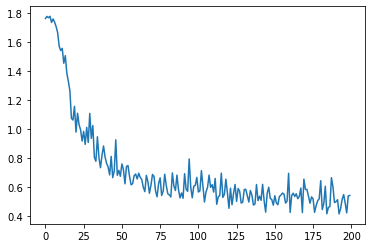

In [12]:
plt.figure()
plt.plot(training_loss)